In [43]:
%matplotlib inline
import matplotlib.pylab as pl

import pandas as pd
import numpy as np

import sklearn as sk
import contextlib
import statsmodels.api as sm
import scipy.signal
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import decomposition


sns.set()

In [44]:
#http://stackoverflow.com/questions/2891790/pretty-printing-of-numpy-array
#set a function to manage the print options of specific arrays
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

**Import Data, Check Healthiness, Verify Can Drop NAs**

(this is a preliminary run through, using only NY County, All Industry Sectors, quarterly data from 2000 - 2014)

In [45]:
#reading in QWI indicators for the 4 counties in NYC (New York, Kings)

df = pd.read_csv('~/Documents/GRA/QWI_indicators/qwi_5c2543d712bc416f82683ab99e1517f6.csv')

In [46]:
#print out a list of columns
#df.columns

In [47]:
#remove the flags, which have a lowercase s followed by a capitalized column name
columns_no_flags = [word for word in df.columns if not word[1].isupper()]

#subset to new DF with no flags
df = df[columns_no_flags]
df.columns = [x.replace('.','_') for x in df.columns]

In [48]:
def print_full(x):
    #this function takes in a dataframe and prints the head of the df with all columns displayed
    #it then resets back to the default column display afterwards
    pd.set_option('display.max_columns', 500)
    print(x.head(10))
    pd.reset_option('display.max_columns')
    
#print_full(df)
#df.dtypes

In [49]:
#create new column 'period' that maps the year and quarter
df['period'] = df.year.map(str) + "_" + df.quarter.map(str)


In [50]:
#want data for Manhattan (county = 'New York, NY')
df_ny = df[df.geography_label_value == 'New York, NY']
#only using data from all industries in this example
mask = (df_ny.industry == '00')
df_ny_all = df_ny[mask]
#set the period as the index, so we can keep it when we go to all numerics
df_ny_all = df_ny_all.set_index(df_ny_all.period)


In [51]:
#select numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data = df_ny_all.select_dtypes(include=numerics)

#move period back from index
data.reset_index(level=0, inplace=True)



In [52]:
#drop geography, sex, firmage, firmsize
data.drop(['geography', 'sex', 'firmage', 'firmsize'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


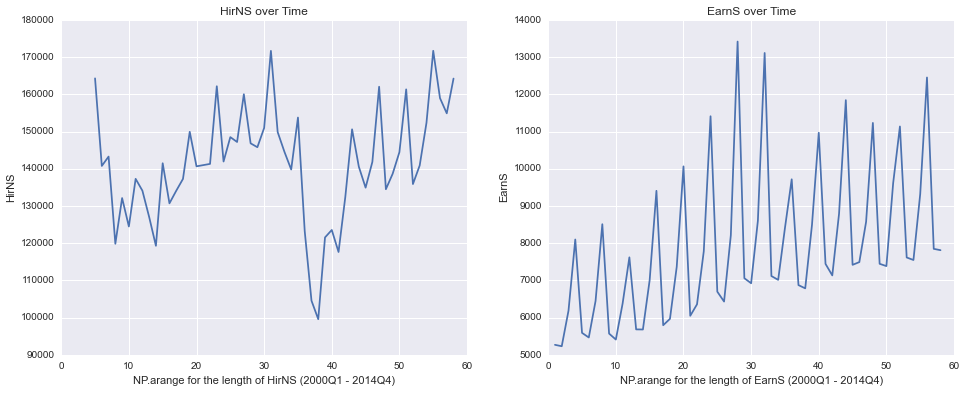

In [53]:
#before drop the NANs, verify position
#from printout, can see there are 6 in HirNS, 2 in EarnS

#check number of NaNs before Drop the values
#print(data.isnull().sum())

#points_ax1 = np.arange(len(data.HirNS))

fig, ((ax1, ax2)) = pl.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirNS)), data.HirNS, label = 'all data')
ax1.set_xlabel('NP.arange for the length of HirNS (2000Q1 - 2014Q4)')
ax1.set_ylabel('HirNS')
ax1.set_title('HirNS over Time')

ax2.plot(np.arange(len(data.EarnS)), data.EarnS, label = 'all data')
ax2.set_xlabel('NP.arange for the length of EarnS (2000Q1 - 2014Q4)')
ax2.set_ylabel('EarnS')
ax2.set_title('EarnS over Time')


#based off the graph below, these are in early 2000 and then again in late 2014. Can now drop them
data = data.dropna()
data = data.reset_index()

In [54]:
data.index = pd.Index(pd.date_range(pd.to_datetime('04/1/2001'), pd.to_datetime('06/30/2014'),freq='Q'))

In [55]:
#cacluate percent change in new hires and add to dataframe
HirN_per = [0]
for i in np.arange(len(data['HirN'])-1):
#    while i < max(np.arange(len(data['HirN']))):
    #for i in len[data.HirN]:
    change = (data.ix[i+1,'HirN'] - data.ix[i,'HirN'])/data.ix[i,'HirN']
    HirN_per.append(change)
#print (HirN_per)

data['HirN_per'] = HirN_per

In [56]:
# add in NY county unemployment rates
df = pd.read_excel('/Users/carlyle/Documents/GRA/QWI_indicators/ny_county_uer.xlsx')
df = df.ix[5:57]
data['NYC_UER'] = (df['ny_uer'].values/100)

In [84]:
#cacluate percent change in new hires and add to dataframe
UER_per = [0]
for i in np.arange(len(data['NYC_UER'])-1):
#    while i < max(np.arange(len(data['HirN']))):
    #for i in len[data.HirN]:
    change = (data.ix[i+1,'NYC_UER'] - data.ix[i,'NYC_UER'])/data.ix[i,'NYC_UER']
    UER_per.append(change)
#print (HirN_per)

data['NYC_UER_per'] = UER_per

In [85]:
data['LMP'] = data['HirN_per'] / data['NYC_UER']
data['LMP_per'] = data['HirN_per'] / data['NYC_UER_per']

**Scatter Matrix and Basic Data Visualization**

In [58]:
#sns.pairplot(data, hue = 'quarter')

In [59]:
cols = list(data.columns)[4:-2]

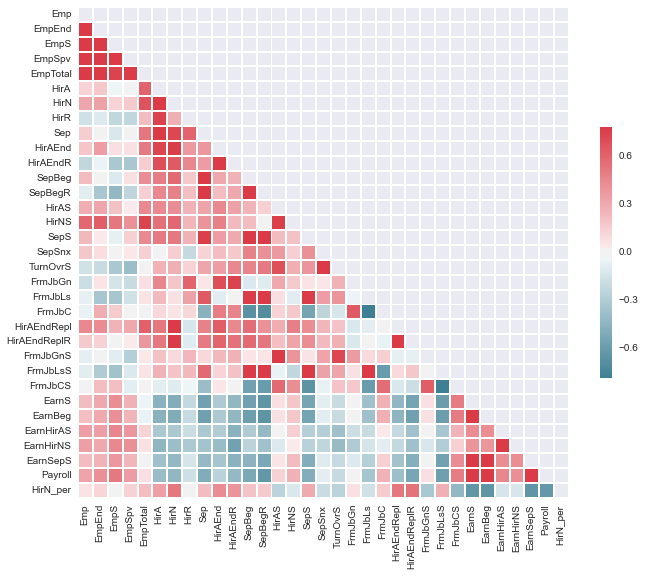

In [60]:
#Correlation Matrix for input variables

# Compute the correlation matrix
corr = data[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = pl.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, #xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [61]:
# fig = pl.figure(figsize=(25,60))
# fig.suptitle('LEHD var vs % Change in New Hires', fontweight='bold', fontsize=26)

# x = 1
# for i in cols:
#     ax1 = fig.add_subplot(11,3,x)
#     fig.tight_layout()
#     ax1.scatter(data[i], data['HirN_per'])
#     ax1.set_ylabel("HirN_per", fontsize = 14)
#     plt.xticks(rotation = 70)
#     ax1.set_title(i, fontsize=20, color='r')
#     x +=1

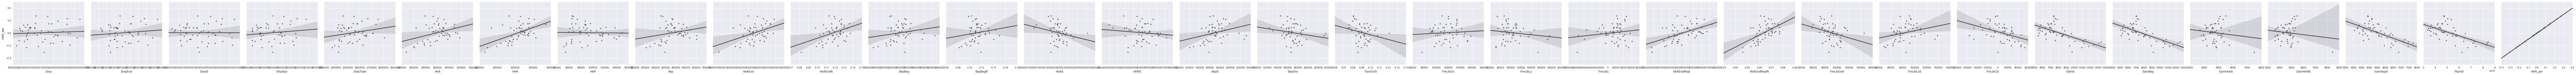

In [62]:
# Every input variable vs. Percent change in new hires
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["HirN_per"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-0.5, 0.5))

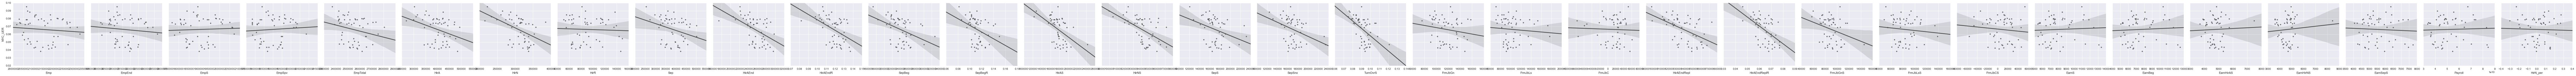

In [63]:
# Every input variable vs. Unemployment Rates
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["NYC_UER"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(0.02, 0.1))

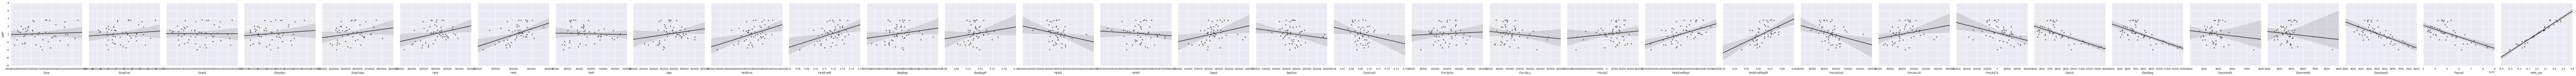

In [64]:
# Every input variable vs. Unemployment Rates
# graphs have a simple linear regression bar through plot with shaded 95% CI zone
# double click to zoom in 

g = sns.PairGrid(data, y_vars=["LMP"], x_vars=cols, size=4)
g.map(sns.regplot, color=".3")
#g.set(ylim=(-.5, 0.5))

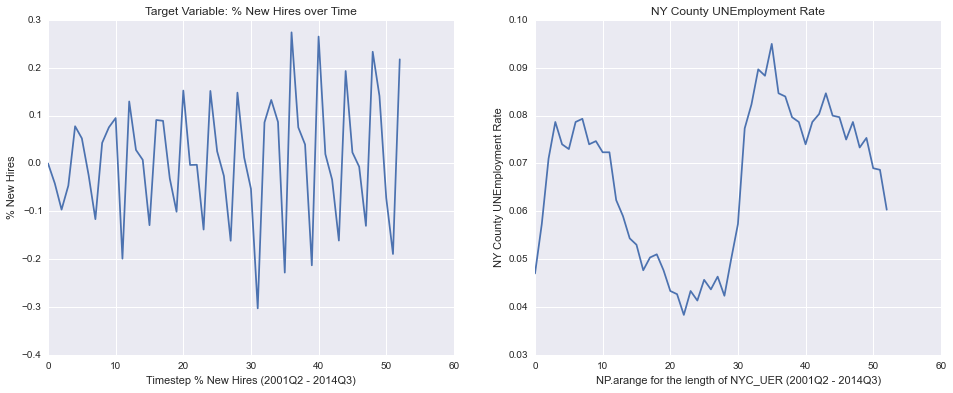

In [65]:
fig, ((ax1, ax2)) = pl.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirN_per)), data.HirN_per, label = 'all data')
ax1.set_xlabel('Timestep % New Hires (2001Q2 - 2014Q3)')
ax1.set_ylabel('% New Hires')
ax1.set_title('Target Variable: % New Hires over Time')

ax2.plot(np.arange(len(data.NYC_UER)), data.NYC_UER, label = 'all data')
ax2.set_xlabel('NP.arange for the length of NYC_UER (2001Q2 - 2014Q3)')
ax2.set_ylabel('NY County UNEmployment Rate')
ax2.set_title('NY County UNEmployment Rate')


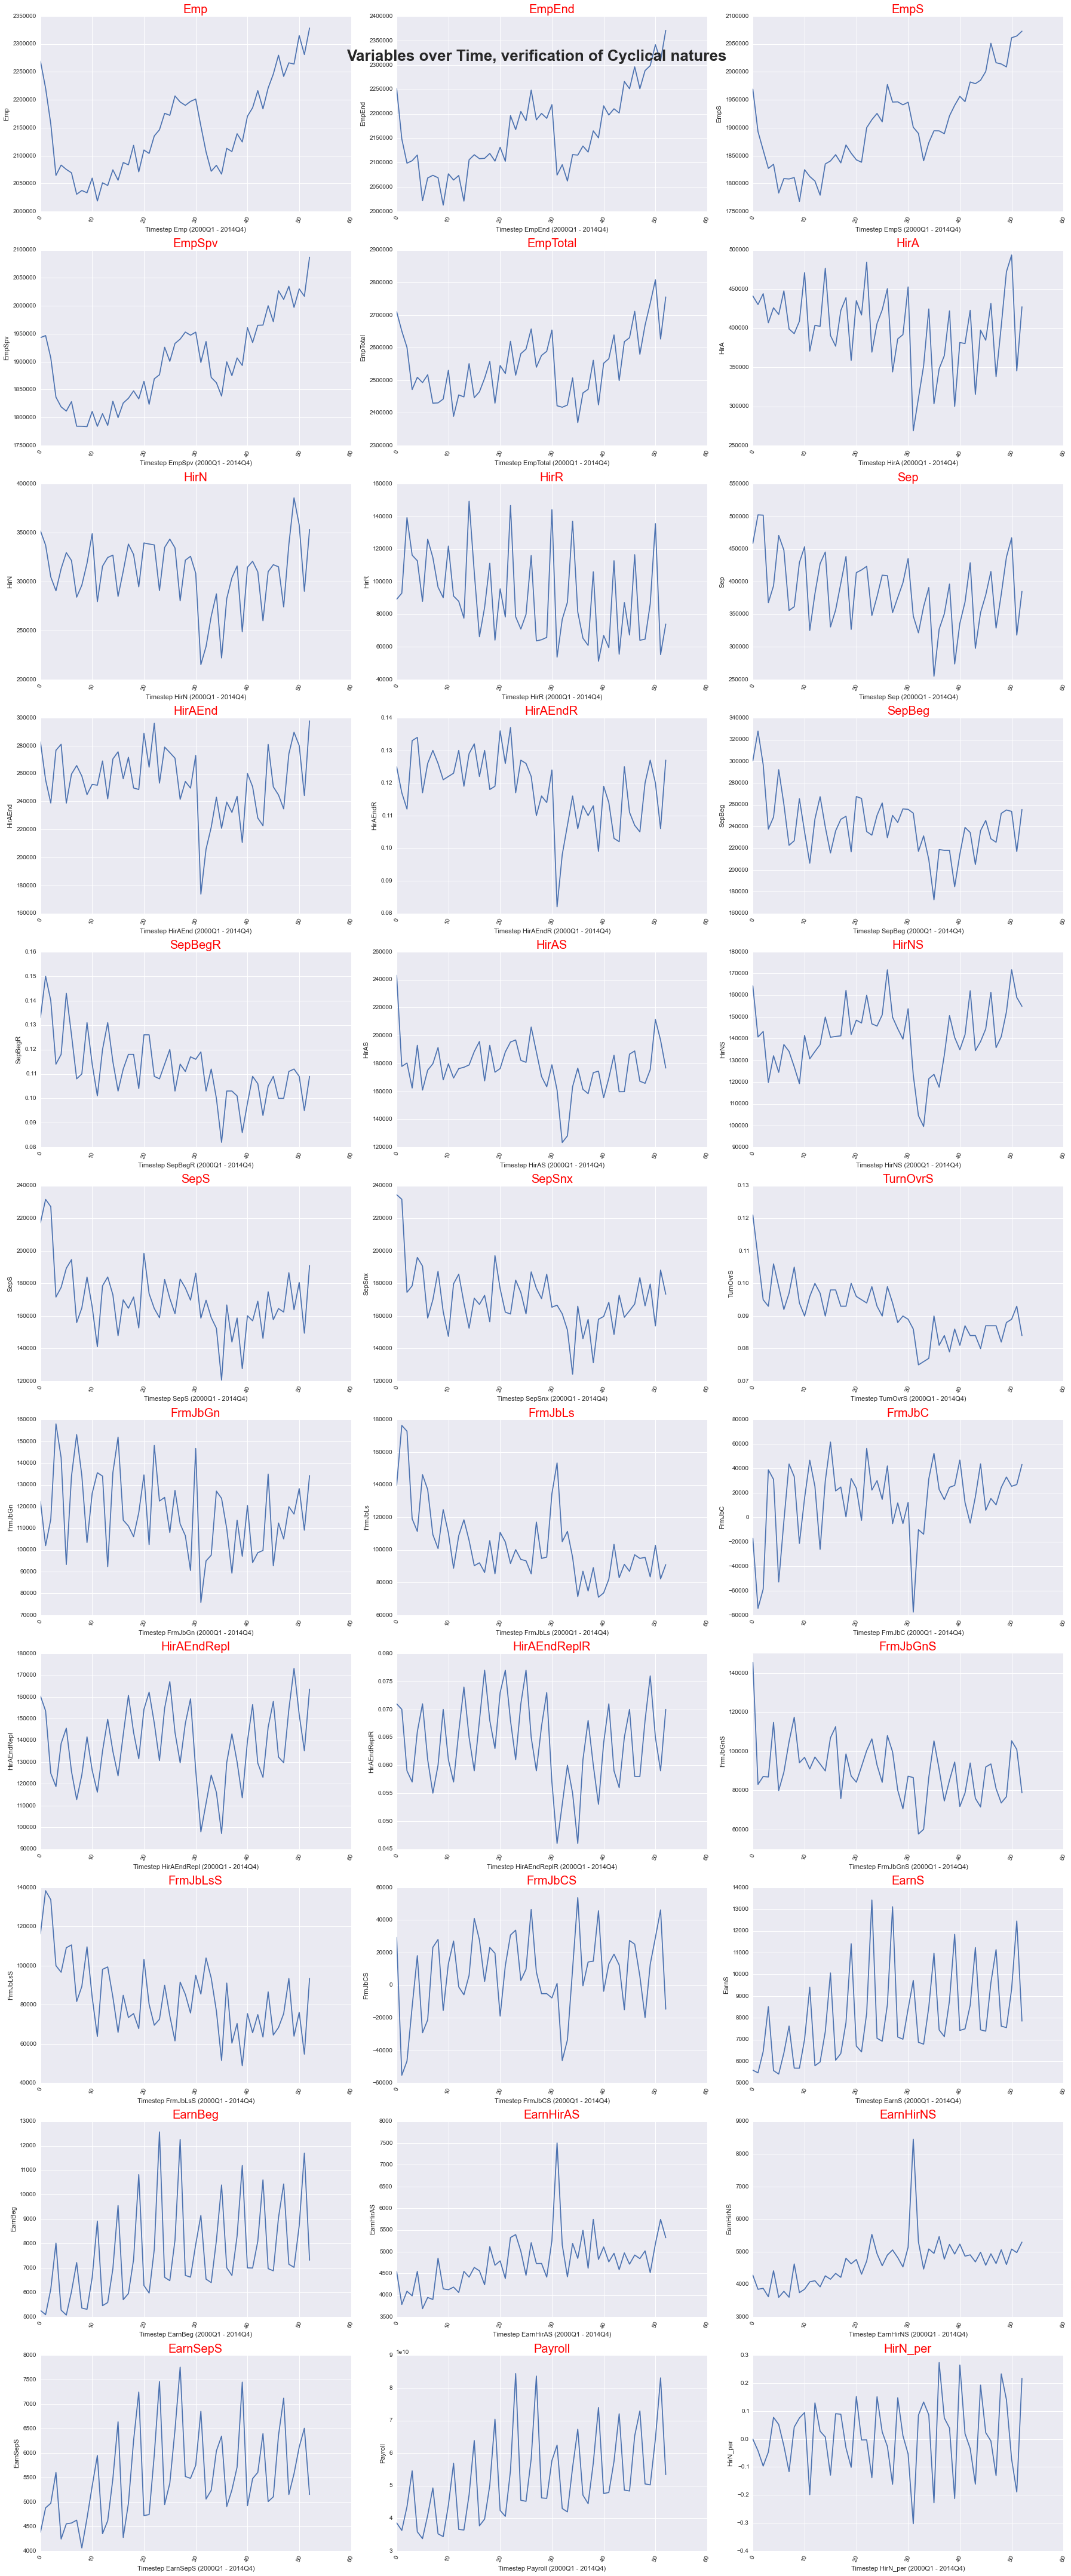

In [66]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, verification of Cyclical natures', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(np.arange(len(data[i])), data[i], label = 'all data')
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    ax1.set_title('Target Variable: % New Hires over Time')
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    x +=1

In [67]:
#variables for the PCA
inputs = ['EmpTotal', 'HirN', 'HirR', 'HirAEndR', 'SepBegR', 'HirAS', 'FrmJbC', 
          'HirAEndReplR', 'EarnS', 'EarnHirNS']

/usr/local/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


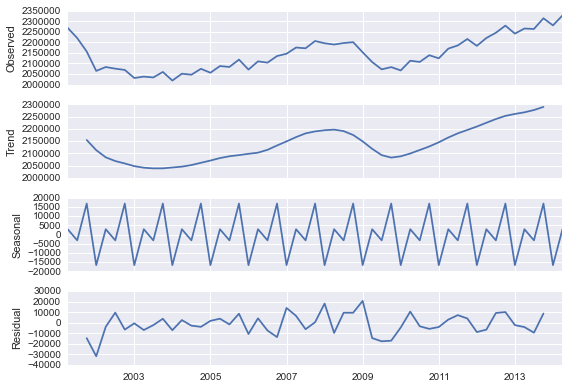

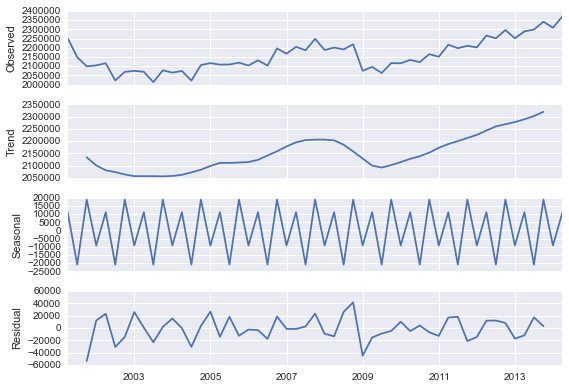

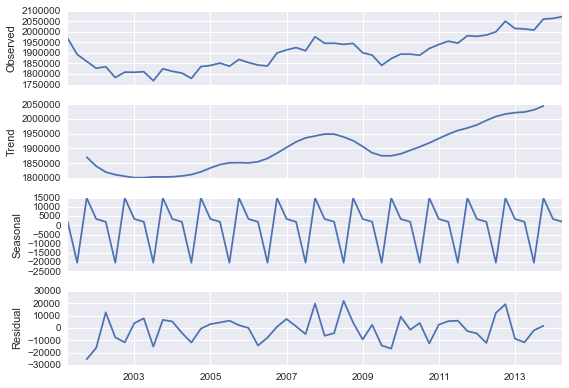

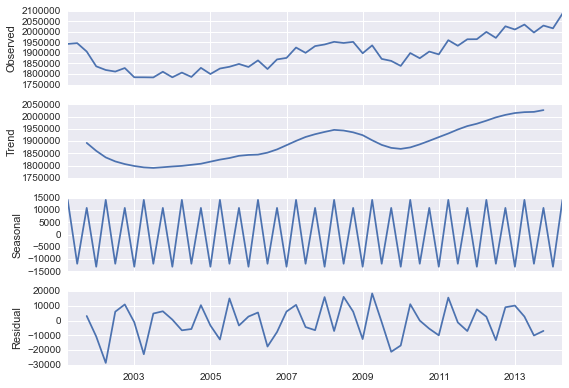

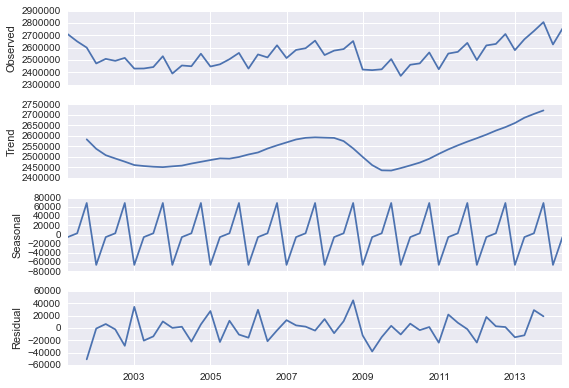

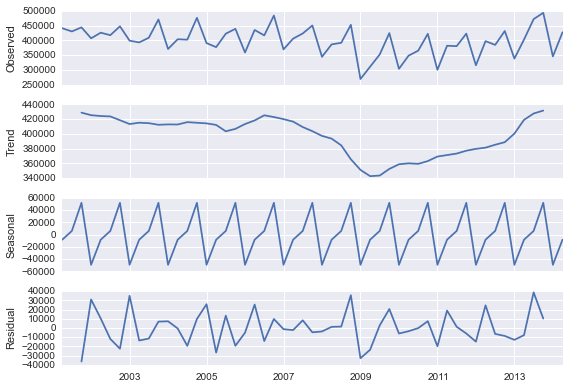

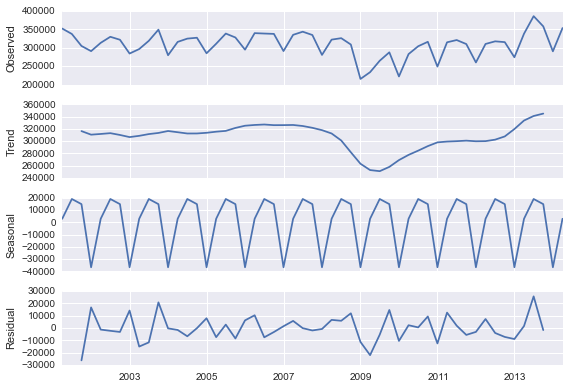

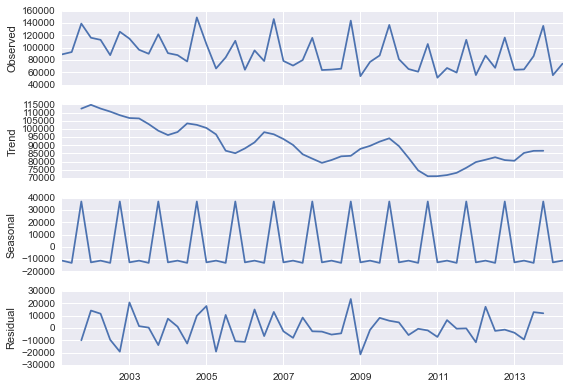

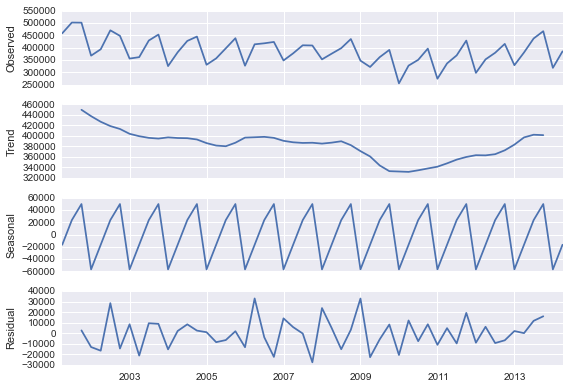

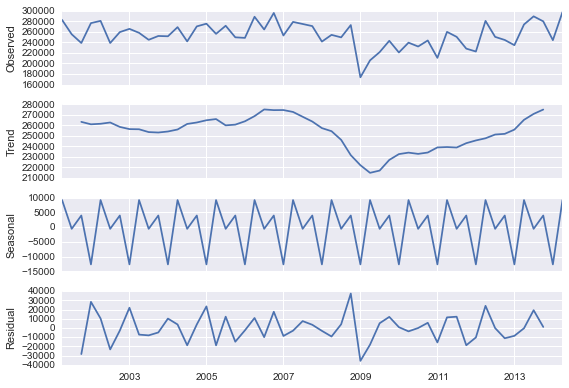

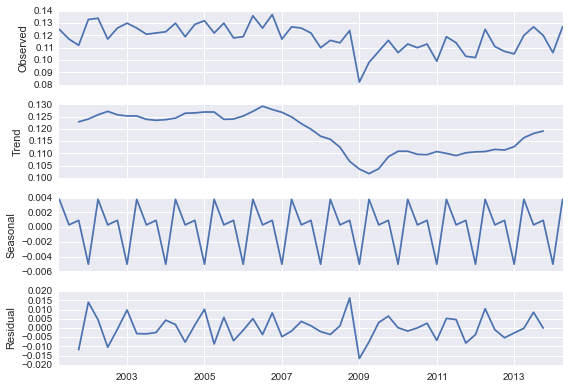

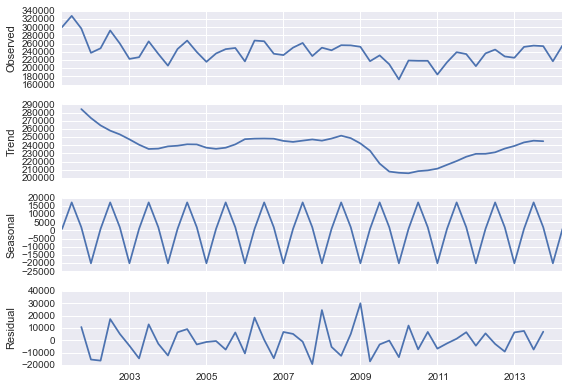

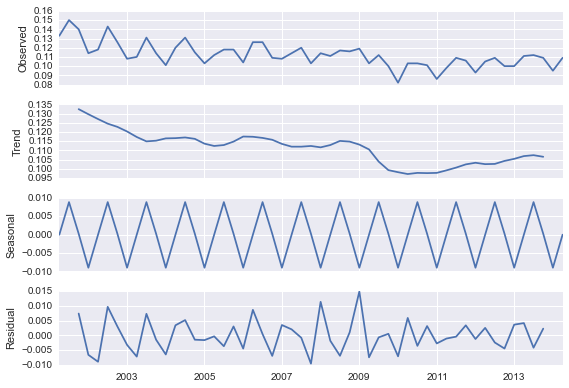

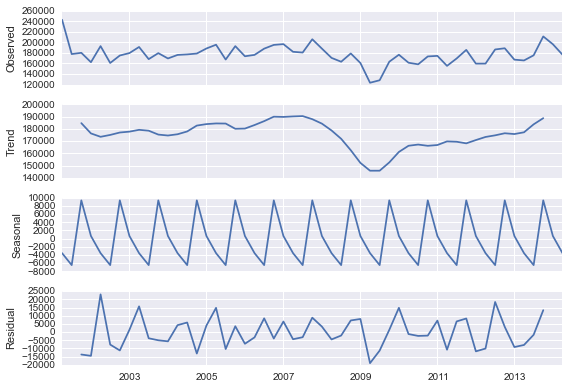

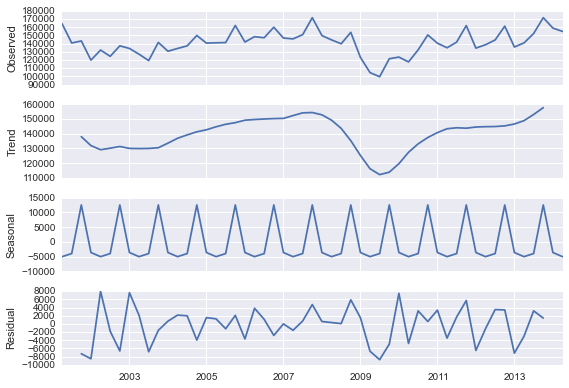

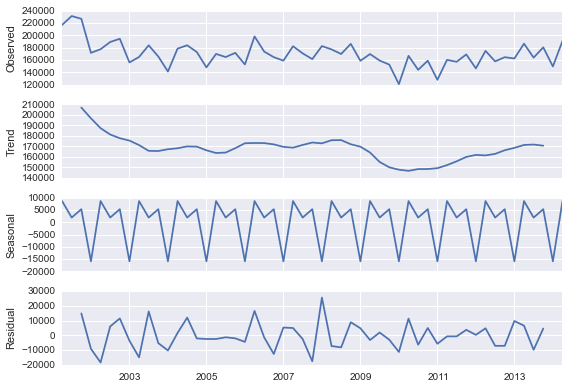

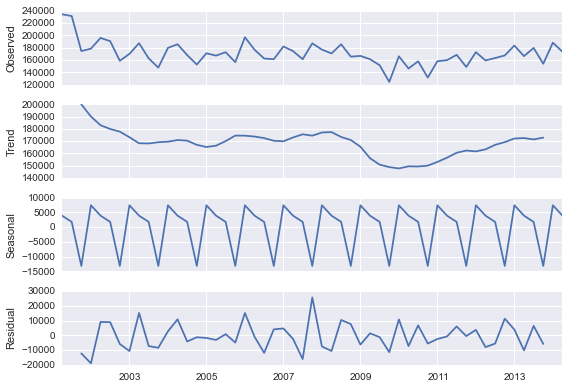

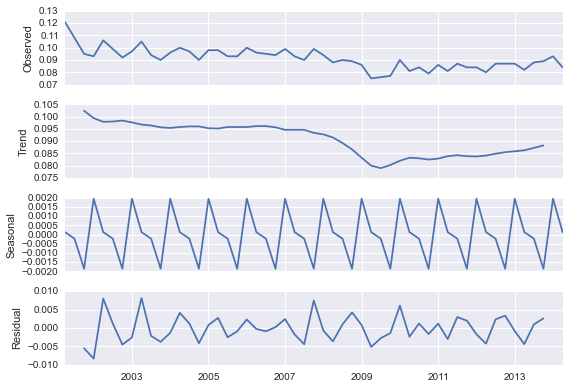

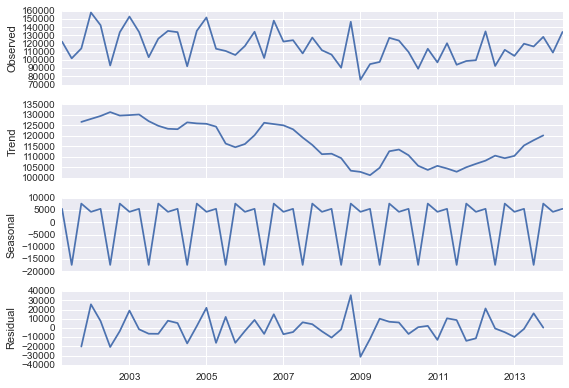

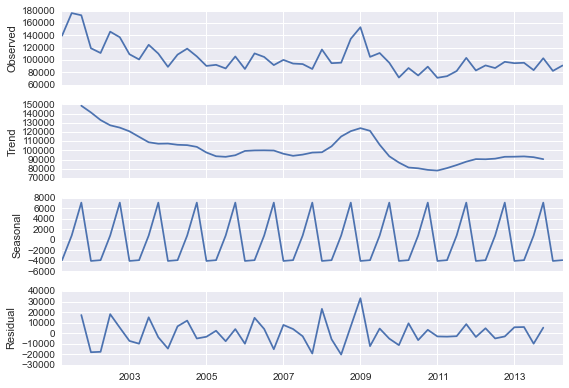

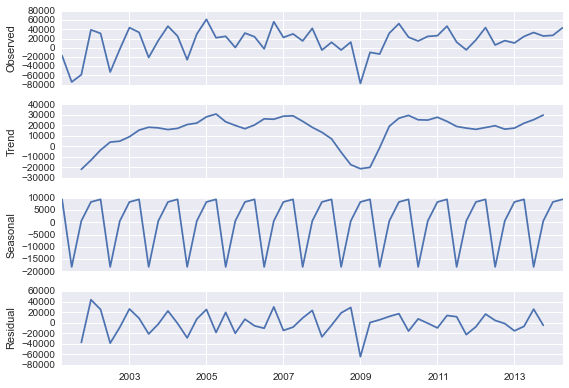

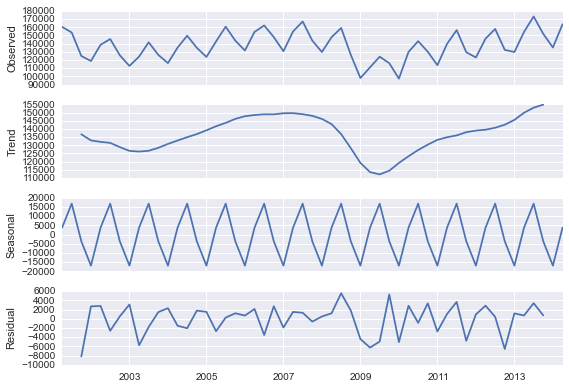

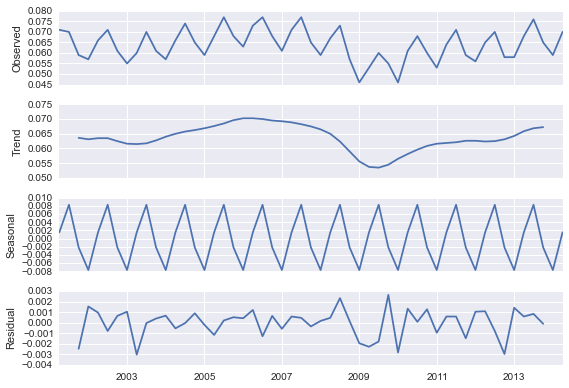

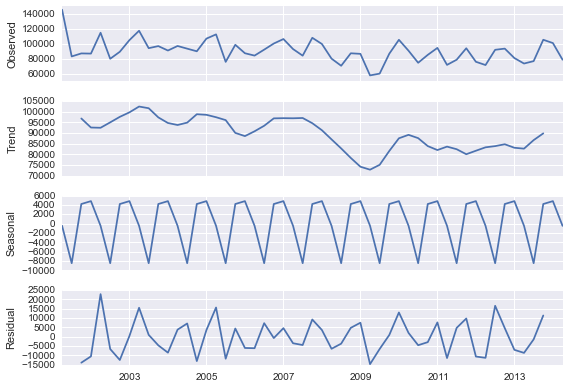

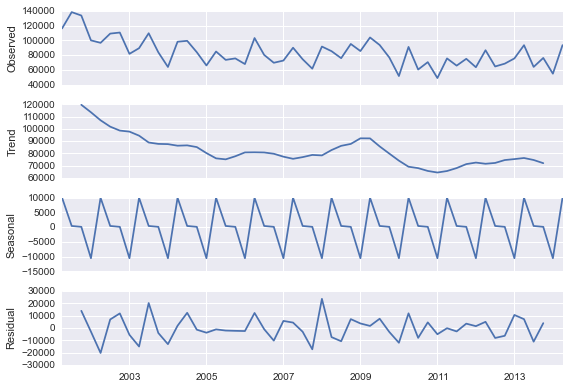

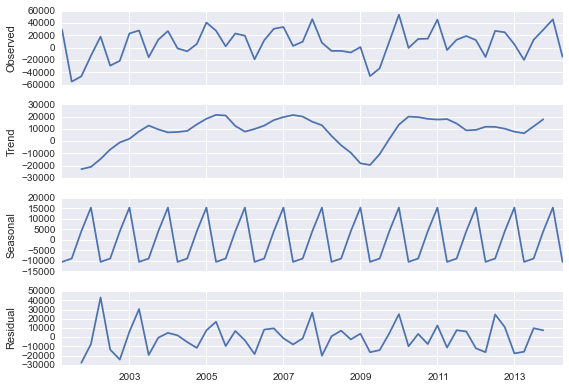

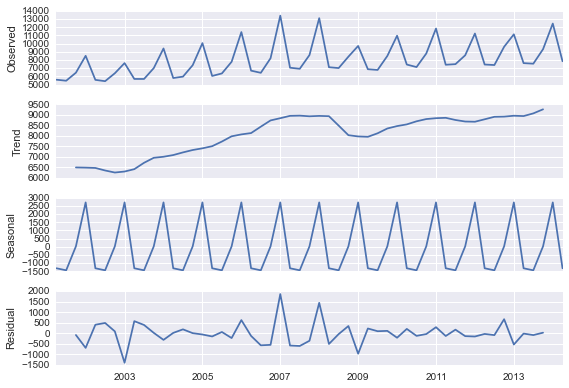

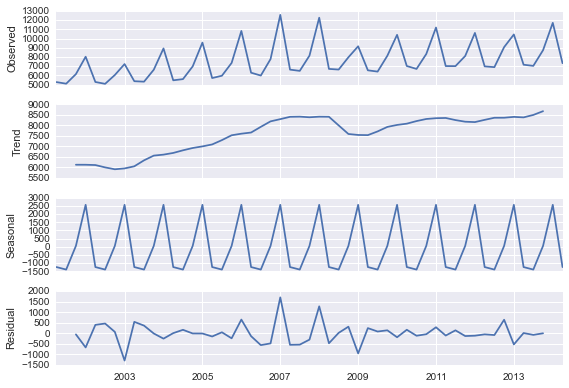

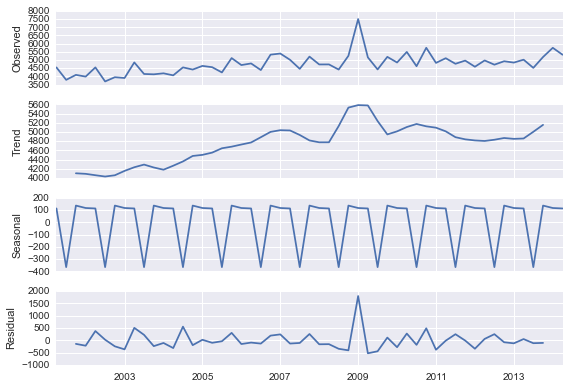

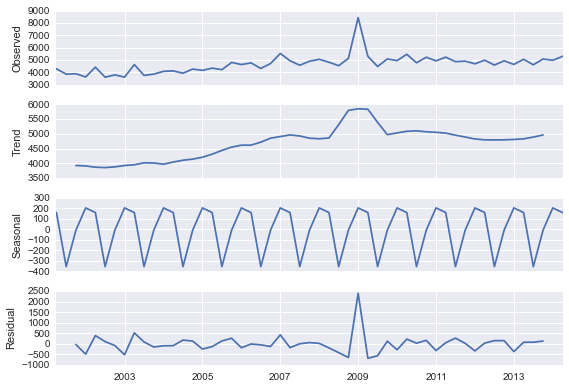

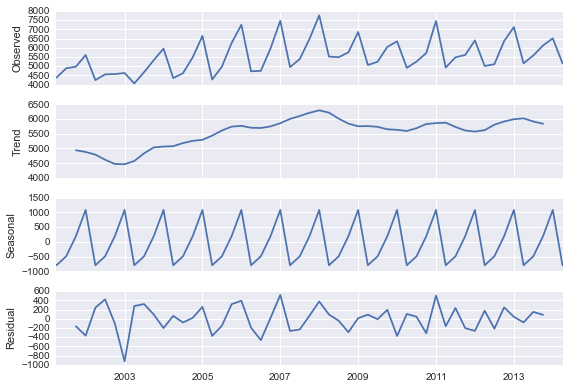

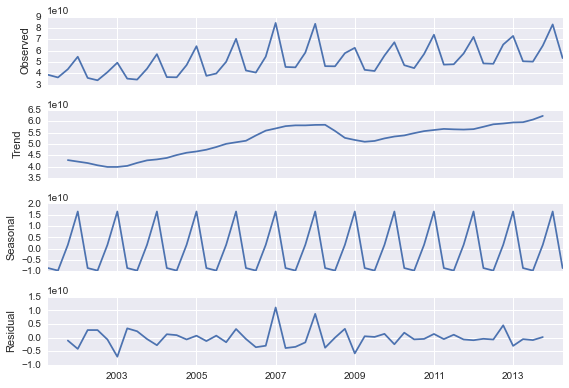

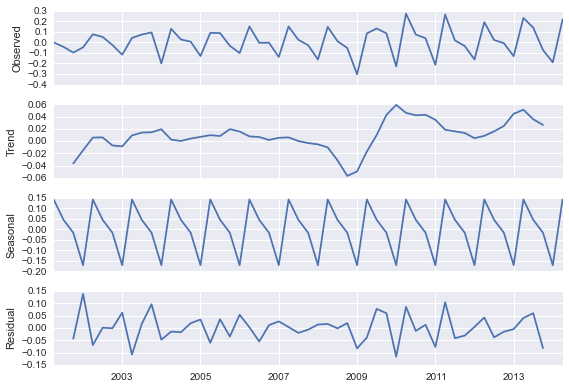

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, DECOMPOSITION PLOT', fontweight='bold', fontsize=26)

x = 1
for i in cols:
    
    decomposition = seasonal_decompose(data[i])  
 
    #ax1 = fig.add_subplot(11,3,x)
    #fig.tight_layout()
    #ax1 = 
    decomposition.plot()  
    x +=1

In [69]:
# data.head()
# data.drop(['index'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


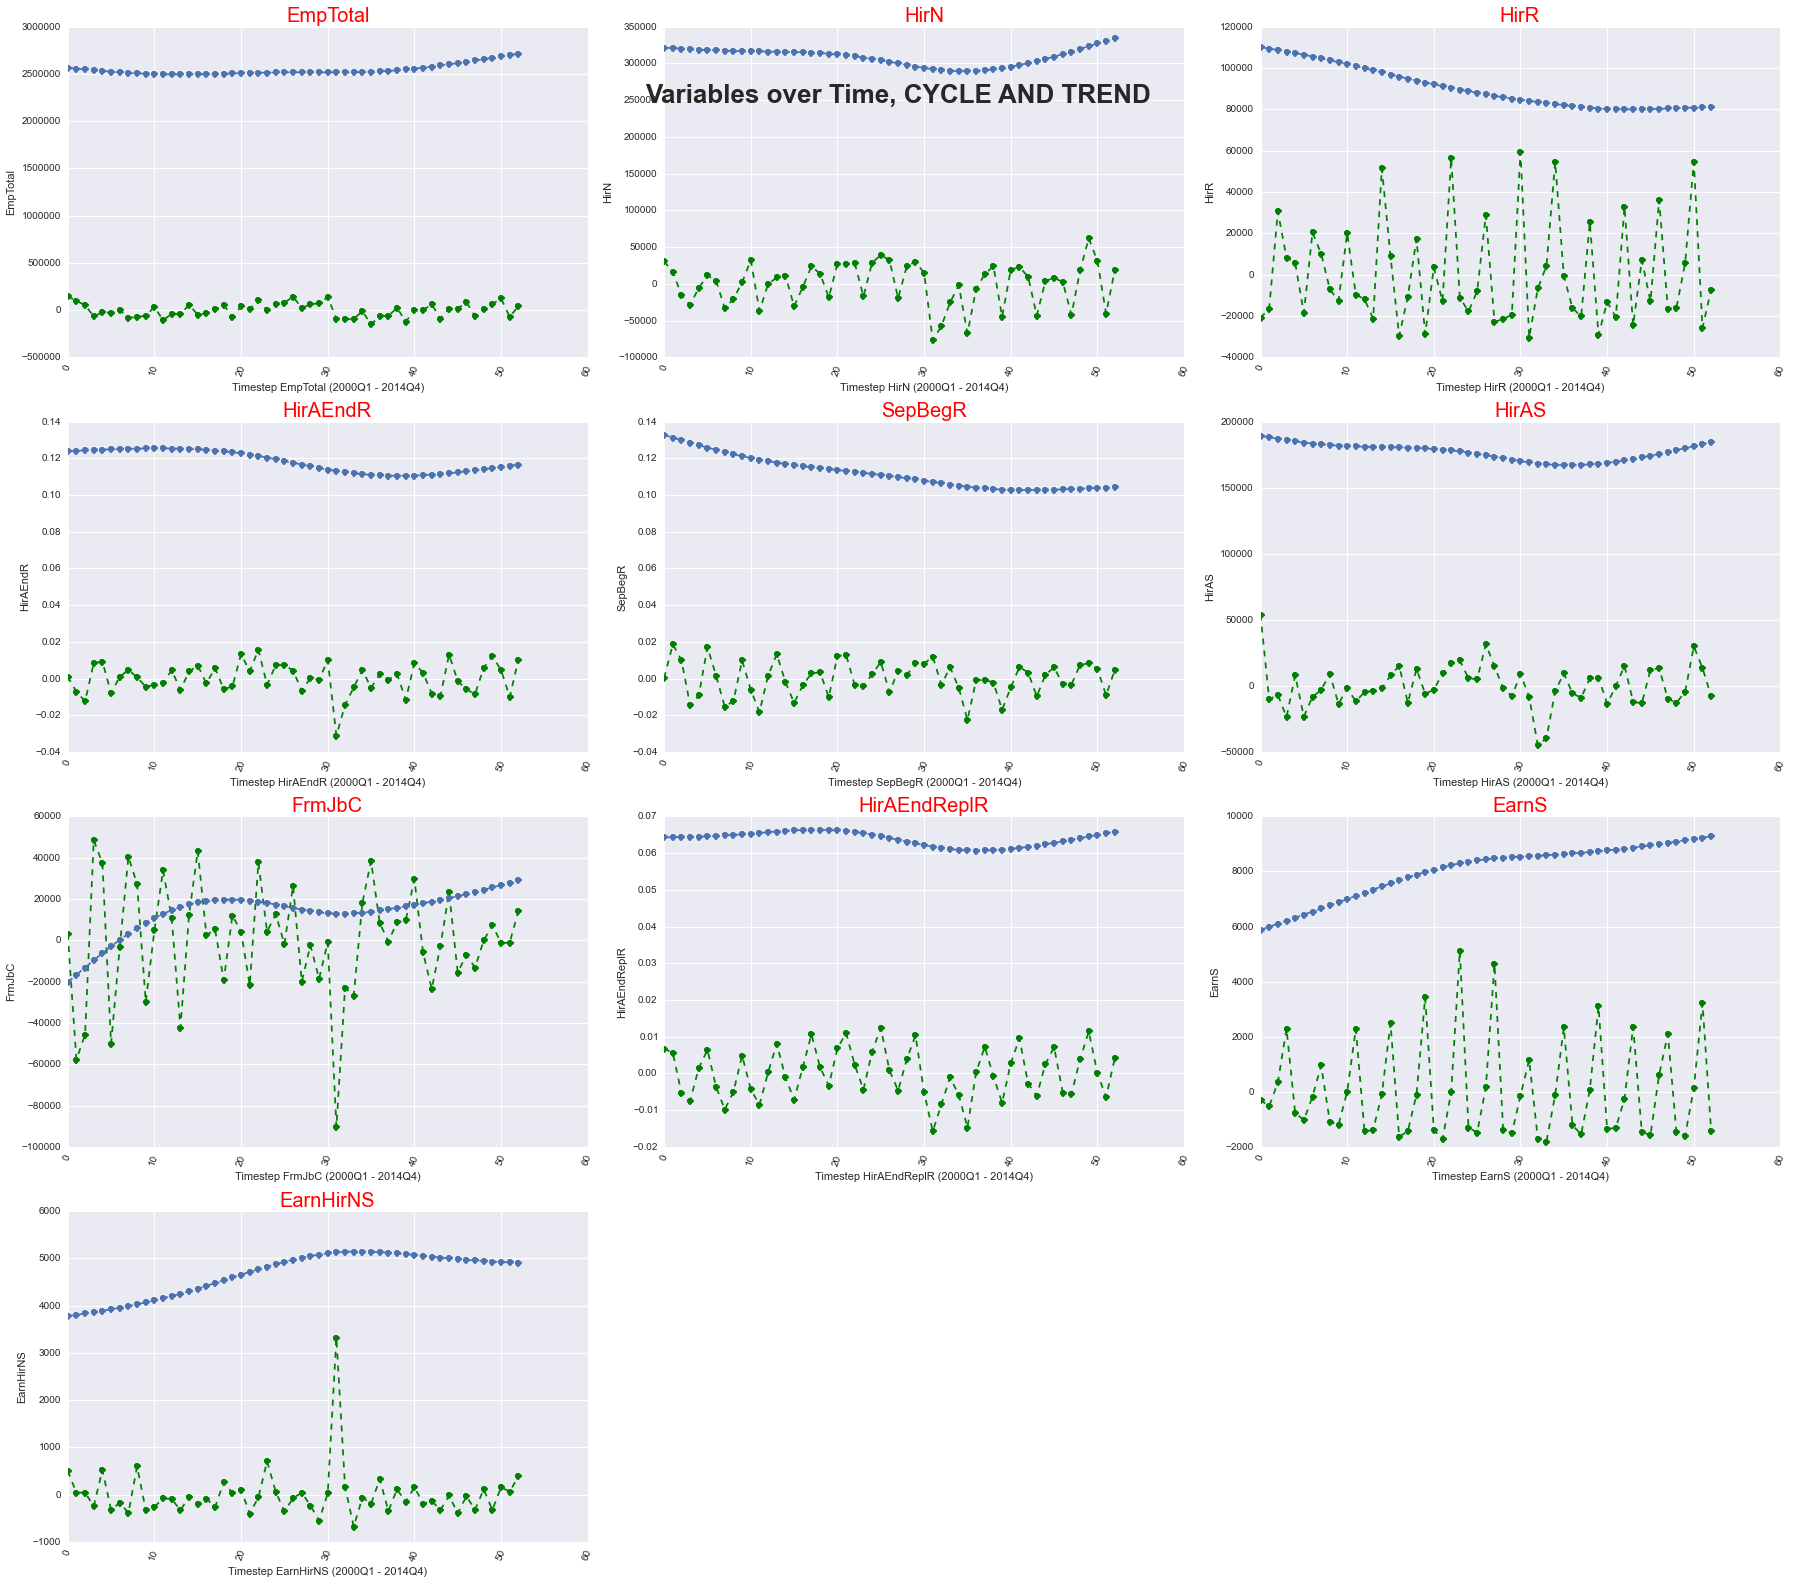

In [70]:
fig = pl.figure(figsize=(25,60))
fig.suptitle('Variables over Time, CYCLE AND TREND', fontweight='bold', fontsize=26)

cycles = {}

x = 1
#for i in cols:
for i in inputs:
    
    cycle, trend = sm.tsa.filters.hpfilter(data[i], 1600)
    cycles[i] = cycle
    
    ax1 = fig.add_subplot(11,3,x)
    fig.tight_layout()
    ax1.plot(cycle, marker='o', linestyle='--', color = 'g')  
    ax1.plot(trend, marker='o', linestyle='--')  
    ax1.set_xlabel('Timestep {0} (2000Q1 - 2014Q4)'.format(i))
    ax1.set_ylabel('{0}'.format(i))
    pl.xticks(rotation = 70)
    ax1.set_title(i, fontsize=20, color='r')
    ax1.legend()
    x +=1


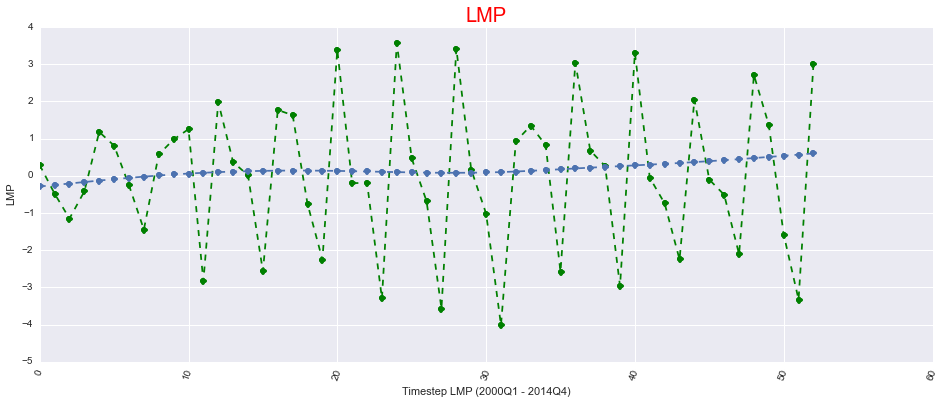

In [71]:
cycle, trend = sm.tsa.filters.hpfilter(data['LMP'], 1600)
HirN_per_trend = trend
fig, (ax1) = pl.subplots(figsize=(16,6), nrows=1, ncols=1)


ax1.plot(cycle, marker='o', linestyle='--', color = 'g')  
ax1.plot(trend, marker='o', linestyle='--')  
ax1.set_xlabel('Timestep LMP (2000Q1 - 2014Q4)')
ax1.set_ylabel('LMP')
pl.xticks(rotation = 70)
ax1.set_title('LMP', fontsize=20, color='r')


In [72]:
#save cycles into a new dataframe
input_cycles = pd.DataFrame(cycles)

In [73]:
input_cycles['LMP'] = data['LMP'].values

In [74]:
#Covariance Matrix
input_cycles.cov()

EarnHirNS           EarnS          EmpTotal  \
EarnHirNS       297,817.690     160,095.241    -2,295,915.463   
EarnS           160,095.241   3,188,240.708   -38,631,742.381   
EmpTotal     -2,295,915.463 -38,631,742.381 5,423,766,303.047   
FrmJbC       -4,319,728.281   8,010,543.488  -134,188,606.117   
HirAEndR             -1.775          -5.217           259.482   
HirAEndReplR         -1.330          -8.093           245.691   
HirAS         1,251,206.273   6,757,001.622   616,521,672.728   
HirN         -5,156,720.701 -30,899,173.644 1,726,104,443.271   
HirR         -1,456,527.872  -2,208,019.778   884,892,586.453   
SepBegR               0.362          -9.012           324.338   
LMP                -240.766      -2,891.711        35,608.949   

                       FrmJbC  HirAEndR  HirAEndReplR           HirAS  \
EarnHirNS      -4,319,728.281    -1.775        -1.330   1,251,206.273   
EarnS           8,010,543.488    -5.217        -8.093   6,757,001.622   
EmpTotal     -134,188,606.117   259.482       245.691 616,521,672.728   
FrmJbC        737,598,245.608   159.004       -25.109  89,707,702.420   
HirAEndR              159.004     0.000         0.000          21.166   
HirAEndReplR          -25.109     0.000         0.000           6.945   
HirAS          89,707,702.420    21.166         6.945 269,223,214.877   
HirN           32,078,760.058   155.857       166.931 135,007,436.728   
HirR          170,581,697.637    75.940       -31.628  83,371,271.707   
SepBegR              -189.948    -0.000         0.000         -19.873   
LMP                 7,500.411     0.009         0.008      -8,411.811   

                          HirN            HirR  SepBegR        LMP  
EarnHirNS       -5,156,720.701  -1,456,527.872    0.362   -240.766  
EarnS          -30,899,173.644  -2,208,019.778   -9.012 -2,891.711  
EmpTotal     1,726,104,443.271 884,892,586.453  324.338 35,608.949  
FrmJbC          32,078,760.058 170,581,697.637 -189.948  7,500.411  
HirAEndR               155.857          75.940   -0.000      0.009  
HirAEndReplR           166.931         -31.628    0.000      0.008  
HirAS          135,007,436.728  83,371,271.707  -19.873 -8,411.811  
HirN           880,950,985.653 191,813,350.574  142.575 34,578.041  
HirR           191,813,350.574 626,652,260.550  -12.730   -745.653  
SepBegR                142.575         -12.730    0.000      0.006  
LMP                 34,578.041        -745.653    0.006      3.944

**Principle Component Analysis, v1**

(using all columns -- doing with sklearn)

In [75]:
#convert dataframe to a numpy array
sk_data= input_cycles.as_matrix()
print(sk_data.shape)

#drop the first three columns: period, year, quarter -- all that remains are the numeric indicator columns
y = sk_data[:,-1]
X = sk_data[:,:-1]
# print(X.shape)
# print(y.shape)



(53, 11)


In [76]:
#CYCLES OF DATA:

principles = 3

pca = sk.decomposition.PCA(n_components = principles)
pca.fit(X)
X_t = pca.transform(X)
#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA, Explained Variance Ratio:\n', pca.explained_variance_ratio_) 

#get the weights of each of the features by vector space
i = np.identity(X.shape[1])

coef = pca.transform(i)
weights = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3'],
                       index=inputs)


print('PCA PARAMETERS:\n', pca.get_params(),'\n')

pd.options.display.float_format = '{:,.3f}'.format
print('PCA WEIGHTS: \n', weights)
    

PCA, Explained Variance Ratio:
 [ 0.783  0.106  0.059]
PCA PARAMETERS:
 {'n_components': 3, 'copy': True, 'whiten': False} 

PCA WEIGHTS: 
                PC-1   PC-2   PC-3
EmpTotal     -0.001  0.005 -0.007
HirN         -0.007 -0.012 -0.023
HirR          0.931  0.074 -0.067
HirAEndR     -0.014 -0.888  0.350
SepBegR      -0.000 -0.000  0.000
HirAS        -0.000  0.000  0.000
FrmJbC        0.106 -0.122  0.037
HirAEndReplR  0.309  0.001  0.581
EarnS         0.159 -0.437 -0.731
EarnHirNS    -0.000  0.000  0.000


In [77]:
#NORMALIZED CYCLES OF DATA:

X_norm = sk.preprocessing.normalize(X, norm='l2', axis=0, copy=True)

principles = 3

pca = sk.decomposition.PCA(n_components = principles)
pca.fit(X_norm)
X_norm_t = pca.transform(X_norm)
#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:\n', pca.explained_variance_ratio_) 

#get the weights of each of the features by vector space
i = np.identity(X_norm.shape[1])

coef = pca.transform(i)
weights = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3'],
                       index=inputs)


print('PCA PARAMETERS:\n', pca.get_params(),'\n')

pd.options.display.float_format = '{:,.3f}'.format
print('PCA WEIGHTS: \n', weights)

PCA WITH FEATURES NORMALIZED, Explained Variance Ratio:
 [ 0.379  0.244  0.157]
PCA PARAMETERS:
 {'n_components': 3, 'copy': True, 'whiten': False} 

PCA WEIGHTS: 
                PC-1   PC-2   PC-3
EmpTotal     -0.179  0.201 -0.464
HirN         -0.357 -0.193 -0.262
HirR          0.404 -0.067 -0.424
HirAEndR     -0.008 -0.597  0.206
SepBegR       0.329 -0.399  0.197
HirAS         0.443  0.151  0.203
FrmJbC        0.107 -0.248 -0.555
HirAEndReplR  0.494 -0.042 -0.043
EarnS         0.142 -0.313 -0.305
EarnHirNS     0.312  0.466 -0.107


In [36]:
#print('PCA WEIGHTS, PC-1 >0.1: \n', weights[weights['PC-1'].abs() > 0.1])

In [78]:
#y = sk.preprocessing.normalize(y, norm='l2', axis=0, copy=True)


regress = pd.DataFrame(X_norm_t, columns=['PC_1', 'PC_2', 'PC_3'])
regress['y'] = y
regress['y'] = regress['y'].convert_objects(convert_numeric=True)

In [79]:
X1 = regress[['PC_1', 'PC_2', 'PC_3']]
y1 = regress['y']

In [80]:
X1 = sm.add_constant(X1)
est = sm.OLS(y1, X1).fit()

b = est.params

pca_HirN_per = b[0] + b[1]*X_norm_t[:,0] + b[2]*X_norm_t[:,1] + b[3]*X_norm_t[:,2];


est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     24.55
Date:                Tue, 24 Nov 2015   Prob (F-statistic):           7.68e-10
Time:                        16:29:48   Log-Likelihood:                -86.745
No. Observations:                  53   AIC:                             181.5
Df Residuals:                      49   BIC:                             189.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1552      0.178      0.874      0.386        -0.202     0.512
PC_1           4.6492      0.664      7.003      0.000         3.315     5.983
PC_2           0.4809      0.828      0.581      0.564        -1.183     2.144
PC_3           5.0797      1.031      4.927      0.000         3.008     7.152
==============================================================================
Omnibus:                        4.928   Durbin-Watson:                   2.836
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.229
Skew:                           0.431   Prob(JB):                        0.199
Kurtosis:                       2.151   Cond. No.                         5.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
regress2 = pd.DataFrame(X_norm, columns=inputs)

regress2['y'] = y
regress2['y'] = regress2['y'].convert_objects(convert_numeric=True)


X2 = regress2.ix[:,0:-1]
y2 = regress2['y']

X2 = sm.add_constant(X2)
est2 = sm.OLS(y2, X2).fit()

est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     26.30
Date:                Tue, 24 Nov 2015   Prob (F-statistic):           5.97e-15
Time:                        16:29:48   Log-Likelihood:                -58.524
No. Observations:                  53   AIC:                             139.0
Df Residuals:                      42   BIC:                             160.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.1552      0.113      1.378      0.175        -0.072     0.383
EmpTotal        -0.2515      1.139     -0.221      0.826        -2.550     2.047
HirN           -10.5377      1.342     -7.854      0.000       -13.245    -7.830
HirR             0.5143      2.122      0.242      0.810        -3.769     4.797
HirAEndR        33.0358     12.900      2.561      0.014         7.003    59.068
SepBegR        -17.0954      8.833     -1.935      0.060       -34.920     0.729
HirAS           -7.5199      3.135     -2.399      0.021       -13.846    -1.194
FrmJbC          -3.3025      1.291     -2.558      0.014        -5.908    -0.697
HirAEndReplR     7.6454      2.884      2.651      0.011         1.825    13.466
EarnS           -4.6507      1.700     -2.736      0.009        -8.081    -1.221
EarnHirNS       22.8019      9.442      2.415      0.020         3.748    41.856
==============================================================================
Omnibus:                        0.950   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                0.956
Skew:                          -0.171   Prob(JB):                        0.620
Kurtosis:                       2.438   Cond. No.                         161.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
b2 = est2.params

est_HirN_per = b2[0] + b2[1]*X_norm[:,0] + b2[2]*X_norm[:,1] + b2[3]*X_norm[:,2] + b2[4]*X_norm[:,3] 
+ b2[5]*X_norm[:,4] + b2[6]*X_norm[:,5] + b2[7]*X_norm[:,6] + b2[8]*X_norm[:,7]
+  b2[9]*X_norm[:,8] + b2[10]*X_norm[:,9];



<bound method AxesSubplot.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x11ee6d0f0>>

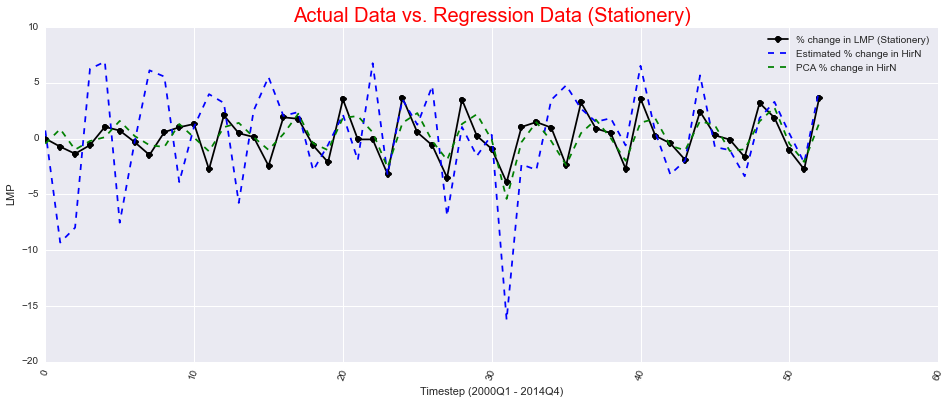

In [83]:
fig, (ax1) = pl.subplots(figsize=(16,6), nrows=1, ncols=1)


ax1.plot(y2, marker='o', linestyle='-', color = 'k', label = '% change in LMP (Stationery)')  
ax1.plot(est_HirN_per + trend, linestyle='--', color = 'b', label = 'Estimated % change in LMP')  
ax1.plot(pca_HirN_per, linestyle='--', color = 'g', label = 'PCA % change in LMP')  

ax1.set_xlabel('Timestep (2001Q2 - 2014Q3)')
ax1.set_ylabel('LMP')
pl.xticks(rotation = 70)
ax1.set_title('Actual Data vs. Regression Data (Stationery)', fontsize=20, color='r')
pl.legend()

ax1.legend
